In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np


In [2]:
transform_input = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1, 1]
])

transform_target = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # [-1, 1]
])


In [3]:
class CIFAR10Pairs(Dataset):
    def __init__(self, root='./data', train=True):
        self.dataset = datasets.CIFAR10(root=root, train=train, download=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        input_img = transform_input(img)     # grayscale
        target_img = transform_target(img)   # color
        return input_img, target_img


In [4]:
train_dataset = CIFAR10Pairs(train=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


100%|██████████| 170M/170M [04:38<00:00, 612kB/s]


In [5]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),   # 32x32 -> 16x16
            nn.ReLU(),

            nn.Conv2d(64, 128, 4, 2, 1), # 16x16 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, 4, 2, 1), # 8x8 -> 4x4
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # 4x4 -> 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 3, 4, 2, 1), # 16x16 -> 32x32
            nn.Tanh()  # output in [-1,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EncoderDecoder().to(device)

# Choose one
criterion = nn.L1Loss()   # better than MSE for images
# criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.0002)


In [7]:
epochs = 20

for epoch in range(epochs):
    total_loss = 0

    for input_img, target_img in train_loader:
        input_img = input_img.to(device)
        target_img = target_img.to(device)

        output = model(input_img)
        loss = criterion(output, target_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/20] Loss: 0.1533
Epoch [2/20] Loss: 0.1202
Epoch [3/20] Loss: 0.1136
Epoch [4/20] Loss: 0.1107
Epoch [5/20] Loss: 0.1071
Epoch [6/20] Loss: 0.1045
Epoch [7/20] Loss: 0.1022
Epoch [8/20] Loss: 0.1011
Epoch [9/20] Loss: 0.1000
Epoch [10/20] Loss: 0.0988
Epoch [11/20] Loss: 0.0980
Epoch [12/20] Loss: 0.0972
Epoch [13/20] Loss: 0.0964
Epoch [14/20] Loss: 0.0958
Epoch [15/20] Loss: 0.0950
Epoch [16/20] Loss: 0.0946
Epoch [17/20] Loss: 0.0939
Epoch [18/20] Loss: 0.0936
Epoch [19/20] Loss: 0.0929
Epoch [20/20] Loss: 0.0923


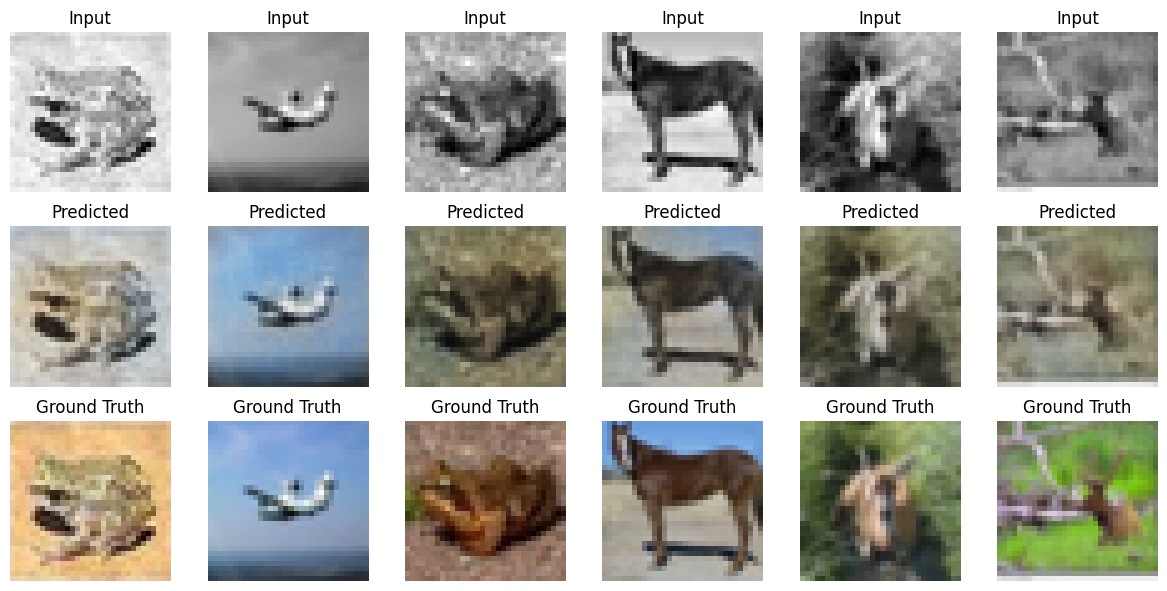

In [8]:
def denorm(img):
    img = img * 0.5 + 0.5
    return img.clamp(0,1)

model.eval()
input_img, target_img = next(iter(train_loader))

with torch.no_grad():
    output = model(input_img.to(device)).cpu()

fig, ax = plt.subplots(3,6, figsize=(12,6))

for i in range(6):
    ax[0,i].imshow(input_img[i][0], cmap='gray')
    ax[0,i].set_title("Input")
    ax[0,i].axis("off")

    ax[1,i].imshow(denorm(output[i]).permute(1,2,0))
    ax[1,i].set_title("Predicted")
    ax[1,i].axis("off")

    ax[2,i].imshow(denorm(target_img[i]).permute(1,2,0))
    ax[2,i].set_title("Ground Truth")
    ax[2,i].axis("off")

plt.tight_layout()
plt.show()
